# 1: Load Data from OracleDB

In [1]:
import sys
import os
import pandas as pd

# Try different paths if needed
sys.path.append(os.path.abspath("../src"))

# Import the function to get the database engine
from database import get_engine

# Connect to OracleDB
engine = get_engine()

df = pd.read_sql("SELECT * FROM bank_reviews_cleaned", con=engine)
df.head()


,review,rating,review_date,app_name
0,accessible to using,5,2025-05-23,Commercial Bank of Ethiopia
1,I like it,4,2025-05-23,Commercial Bank of Ethiopia
2,why you change default network?,5,2025-05-23,Commercial Bank of Ethiopia
3,very nice 👍,5,2025-05-23,Commercial Bank of Ethiopia
4,nice fast app,5,2025-05-23,Commercial Bank of Ethiopia


# 2: Sentiment Analysis with DistilBERT

In [2]:
from sentiment import analyze_sentiments_batch

# Run sentiment analysis
df = analyze_sentiments_batch(df)
df.head()

Device set to use cpu


,review,rating,review_date,app_name,sentiment_label,sentiment_score
0,accessible to using,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999117
1,I like it,4,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999859
2,why you change default network?,5,2025-05-23,Commercial Bank of Ethiopia,NEGATIVE,0.996236
3,very nice 👍,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999858
4,nice fast app,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999833


# Bar Plot: Sentiment Label Counts

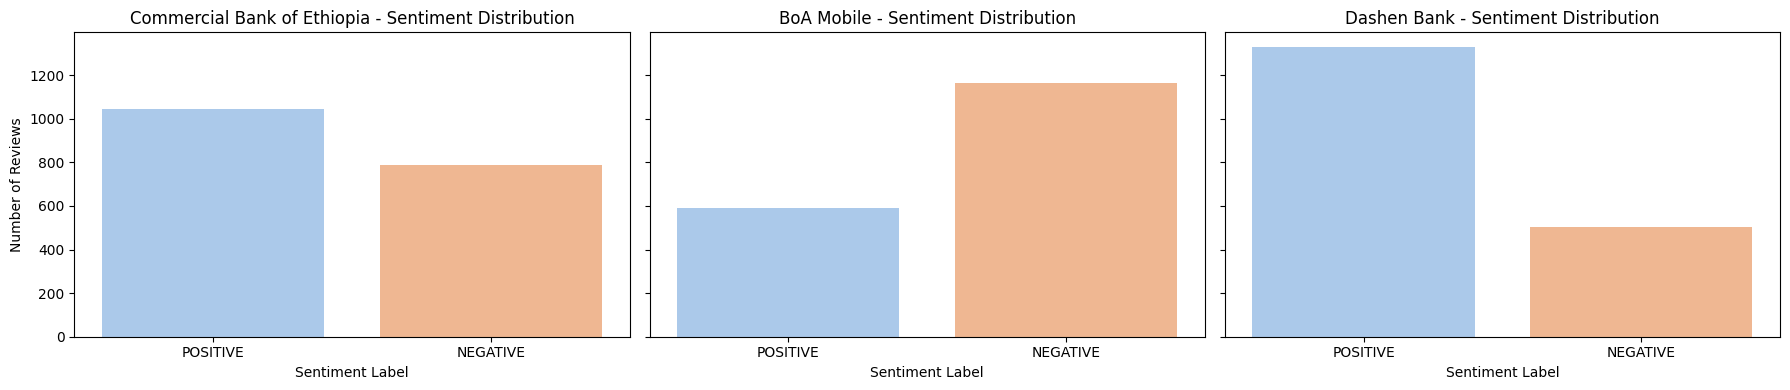

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

banks = df["app_name"].unique()
num_banks = len(banks)

fig, axes = plt.subplots(nrows=1, ncols=num_banks, figsize=(6 * num_banks, 4), sharey=True)

for i, bank in enumerate(banks):
    ax = axes[i] if num_banks > 1 else axes
    sns.countplot(
        data=df[df["app_name"] == bank],
        x="sentiment_label",
        hue="sentiment_label",     # Add this line
        palette="pastel",
        ax=ax,
        legend=False               # Hide redundant legend
    )
    ax.set_title(f"{bank} - Sentiment Distribution")
    ax.set_xlabel("Sentiment Label")
    ax.set_ylabel("Number of Reviews")

plt.tight_layout()
plt.show()


# Heatmap: Average Sentiment Score by Bank and Rating

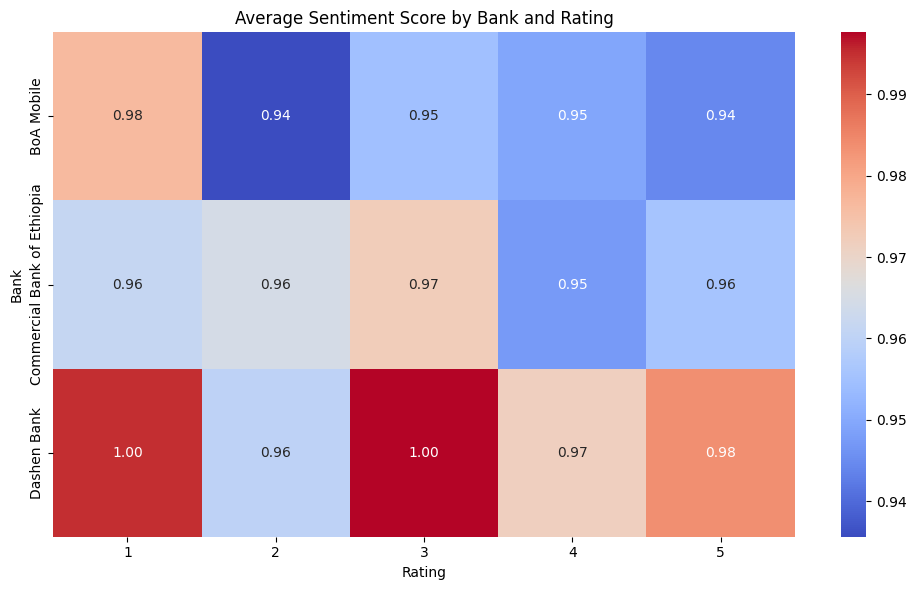

In [4]:
sentiment_pivot = df.pivot_table(
    index="app_name", 
    columns="rating", 
    values="sentiment_score", 
    aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(sentiment_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Sentiment Score by Bank and Rating")
plt.xlabel("Rating")
plt.ylabel("Bank")
plt.tight_layout()
plt.show()


# 3: Aggregation by Bank and Rating

In [5]:
# Group by bank and star rating
agg_by_bank_rating = (
    df.groupby(["app_name", "rating"])
    .agg(
        avg_sentiment_score=("sentiment_score", "mean"),
        count=("review", "count"),
        positive_pct=("sentiment_label", lambda x: (x == "POSITIVE").mean() * 100),
        negative_pct=("sentiment_label", lambda x: (x == "NEGATIVE").mean() * 100)
    )
    .reset_index()
    .sort_values(["app_name", "rating"])
)

# Display summary
agg_by_bank_rating.head(15)

,app_name,rating,avg_sentiment_score,count,positive_pct,negative_pct
0,BoA Mobile,1,0.976536,813,7.995080,92.004920
1,BoA Mobile,2,0.935626,55,9.090909,90.909091
2,BoA Mobile,3,0.954598,130,30.769231,69.230769
3,BoA Mobile,4,0.949280,80,31.250000,68.750000
4,BoA Mobile,5,0.944581,677,67.503693,32.496307
5,Commercial Bank of Ethiopia,1,0.961409,242,15.289256,84.710744
6,Commercial Bank of Ethiopia,2,0.964495,75,20.000000,80.000000
7,Commercial Bank of Ethiopia,3,0.972303,90,11.111111,88.888889
8,Commercial Bank of Ethiopia,4,0.947302,188,45.212766,54.787234
9,Commercial Bank of Ethiopia,5,0.955513,1240,72.580645,27.419355


# Visualize Sentiment Aggregation

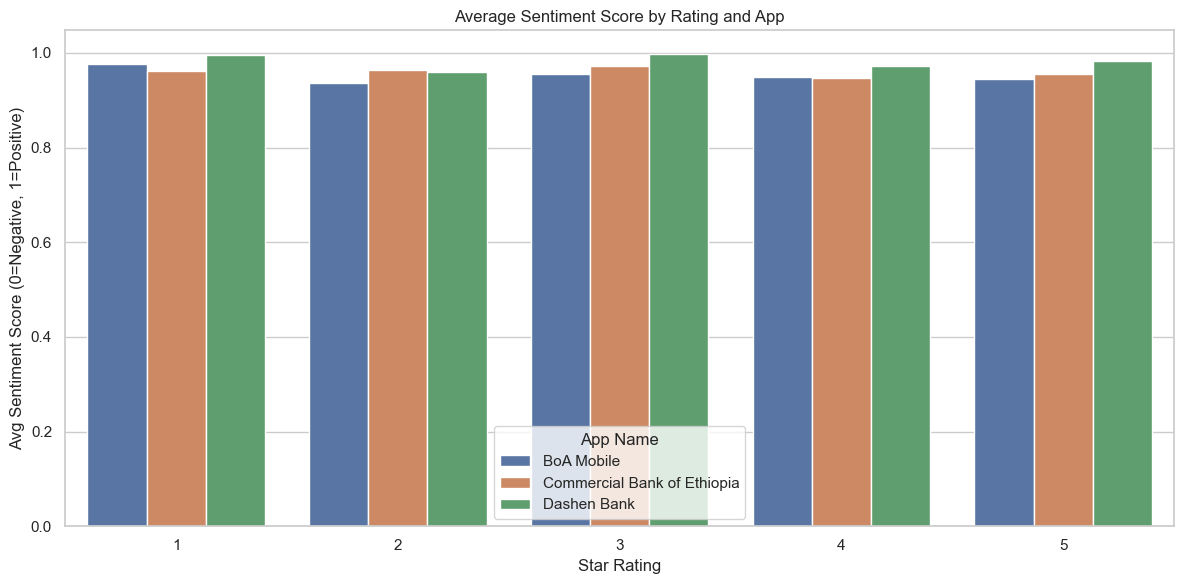

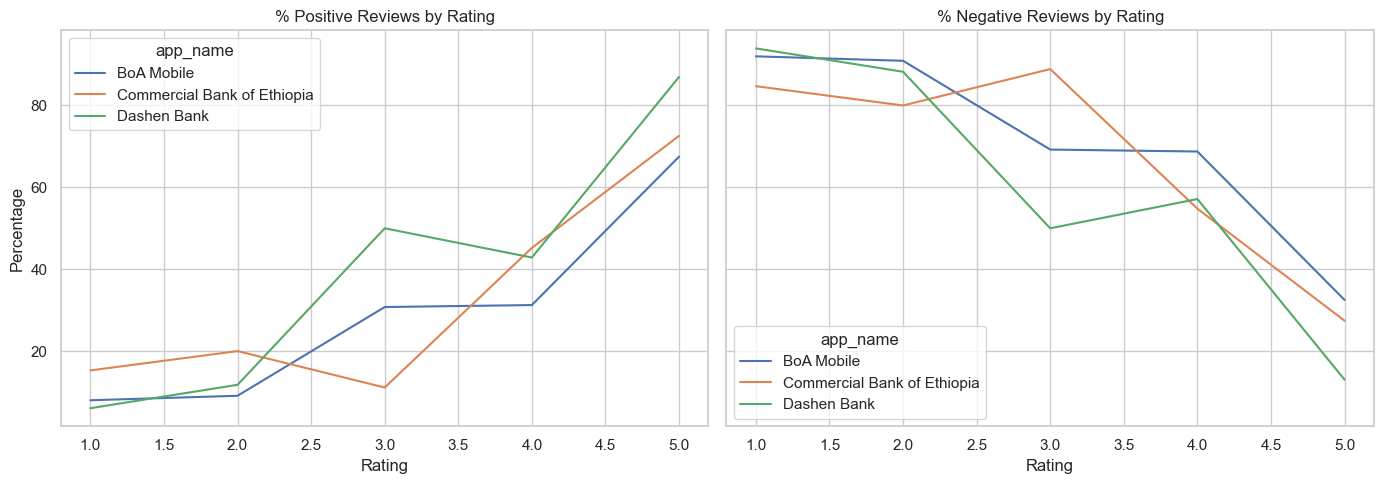

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Bar plot: Avg sentiment score by rating and app
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_by_bank_rating, x="rating", y="avg_sentiment_score", hue="app_name")
plt.title("Average Sentiment Score by Rating and App")
plt.ylabel("Avg Sentiment Score (0=Negative, 1=Positive)")
plt.xlabel("Star Rating")
plt.legend(title="App Name")
plt.tight_layout()
plt.show()

# 2. Line plot: % Positive vs % Negative per rating per app
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.lineplot(data=agg_by_bank_rating, x="rating", y="positive_pct", hue="app_name", ax=axes[0])
axes[0].set_title("% Positive Reviews by Rating")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Rating")

sns.lineplot(data=agg_by_bank_rating, x="rating", y="negative_pct", hue="app_name", ax=axes[1])
axes[1].set_title("% Negative Reviews by Rating")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Rating")

plt.tight_layout()
plt.show()


# 4: Keyword Extraction

from keywords import extract_keywords_tfidf

# Extract keywords
keywords_df = extract_keywords_tfidf(df, text_column="review", max_features=50, ngram_range=(1, 2))
keywords_df.head()


In [7]:
from keywords import extract_keywords_tfidf

bank_keywords = []

# Loop through each bank
for bank_name, group_df in df.groupby("app_name"):
    print(f"Extracting keywords for {bank_name}...")
    
    # Extract keywords for this bank
    keywords_df = extract_keywords_tfidf(group_df, text_column="review", max_features=50, ngram_range=(1, 2))
    
    # Add a column for bank name
    keywords_df["app_name"] = bank_name
    
    bank_keywords.append(keywords_df)

# Combine all results into one DataFrame
all_keywords_df = pd.concat(bank_keywords, ignore_index=True)

# Preview
all_keywords_df.head()


Extracting keywords for BoA Mobile...
Extracting keywords for Commercial Bank of Ethiopia...
Extracting keywords for Dashen Bank...


,keyword,score,app_name
0,app,290.351661,BoA Mobile
1,good,100.023888,BoA Mobile
2,bank,81.320472,BoA Mobile
3,work,68.671213,BoA Mobile
4,boa,65.500403,BoA Mobile


In [8]:
# Assuming all_keywords_df is already created as per your code

# Create separate DataFrames for each bank app
cbe_keywords_df = all_keywords_df[all_keywords_df["app_name"] == "Commercial Bank of Ethiopia"].reset_index(drop=True)
boa_keywords_df = all_keywords_df[all_keywords_df["app_name"] == "BoA Mobile"].reset_index(drop=True)
dashen_keywords_df = all_keywords_df[all_keywords_df["app_name"] == "Dashen Bank"].reset_index(drop=True)

# Preview each
print("CBE Keywords:")
print(cbe_keywords_df.head())

print("\nBOA Keywords:")
print(boa_keywords_df.head())

print("\nDashen Keywords:")
print(dashen_keywords_df.head())

CBE Keywords:
  keyword       score                     app_name
0     app  237.068237  Commercial Bank of Ethiopia
1    good  184.904206  Commercial Bank of Ethiopia
2    best   80.278466  Commercial Bank of Ethiopia
3      ነው   73.792401  Commercial Bank of Ethiopia
4     cbe   73.137523  Commercial Bank of Ethiopia

BOA Keywords:
  keyword       score    app_name
0     app  290.351661  BoA Mobile
1    good  100.023888  BoA Mobile
2    bank   81.320472  BoA Mobile
3    work   68.671213  BoA Mobile
4     boa   65.500403  BoA Mobile

Dashen Keywords:
  keyword       score     app_name
0     app  338.547353  Dashen Bank
1    best  135.940879  Dashen Bank
2  dashen  129.970657  Dashen Bank
3    good  124.034154  Dashen Bank
4    bank  110.313999  Dashen Bank


# Top Keyword Visualization (Bar Chart)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5312\2381924523.py:30: UserWarning: Glyph 4752 (\N{ETHIOPIC SYLLABLE NA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_5312\2381924523.py:30: UserWarning: Glyph 4813 (\N{ETHIOPIC SYLLABLE WE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_5312\2381924523.py:30: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_5312\2381924523.py:30: UserWarning: Glyph 4899 (\N{ETHIOPIC SYLLABLE THAA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_5312\2381924523.py:30: UserWarning: Glyph 4637 (\N{ETHIOPIC SYLLABLE ME}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Admin\OneDrive\10 Academy\Week 2\GitHub Repository\Customer Experience Analytics for Ethiopian Top 3 Banking Apps\.venv\Lib\site-packages\IPython\core\pyl

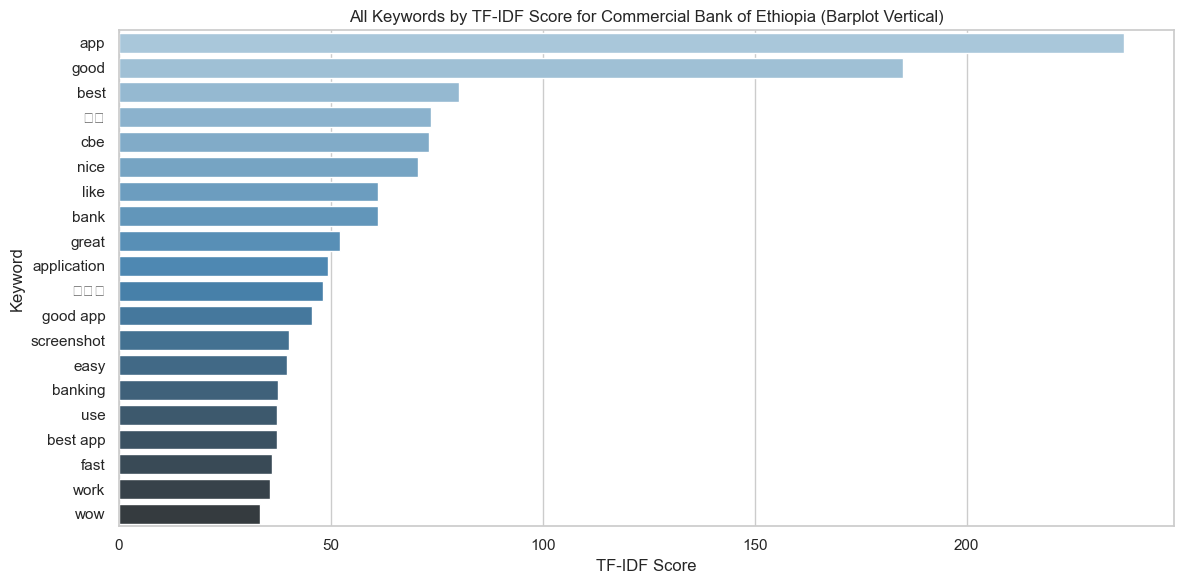

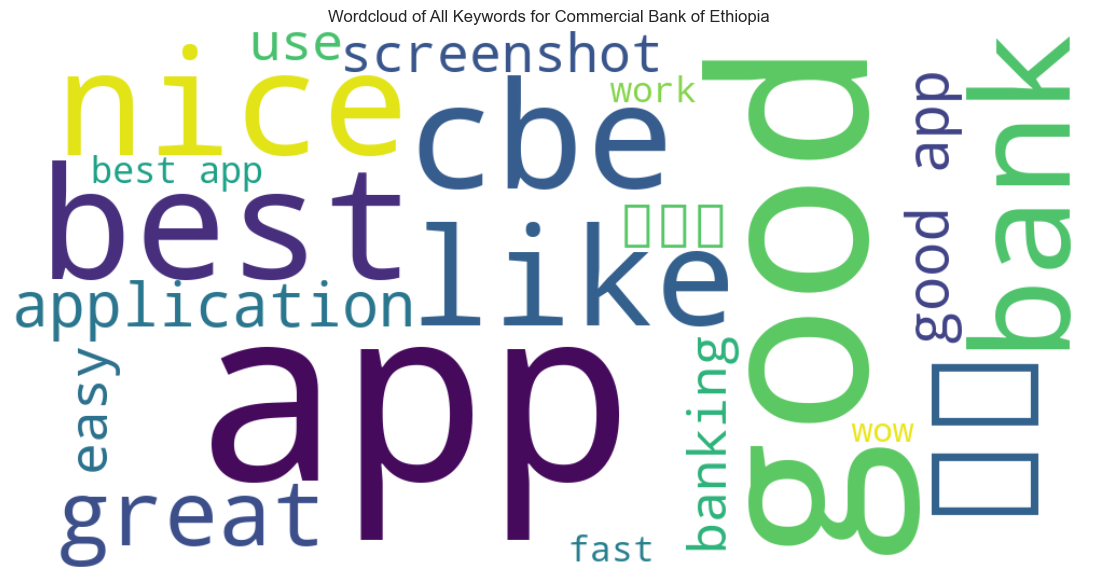

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.font_manager as fm
from matplotlib import rcParams


banks = cbe_keywords_df['app_name'].unique()

for bank in banks:
    # Get all keywords for the current bank
    bank_keywords = cbe_keywords_df[cbe_keywords_df['app_name'] == bank]

    # Sort by score descending and keep only top 20
    top_keywords = bank_keywords.sort_values(by='score', ascending=False).head(20)

    # 1. Barplot (vertical)
    plt.figure(figsize=(12, max(6, 0.3 * len(top_keywords))))  # dynamic height
    sns.barplot(
        data=top_keywords,
        y='keyword',
        x='score',
        palette='Blues_d',
        hue='keyword',
        legend=False
    )
    plt.title(f"All Keywords by TF-IDF Score for {bank} (Barplot Vertical)")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

    # 2. Wordcloud (weighted by TF-IDF score)
    word_freq = dict(zip(top_keywords['keyword'], top_keywords['score']))
    wordcloud = WordCloud(
        width=1000, height=500,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud of All Keywords for {bank}")
    plt.show()


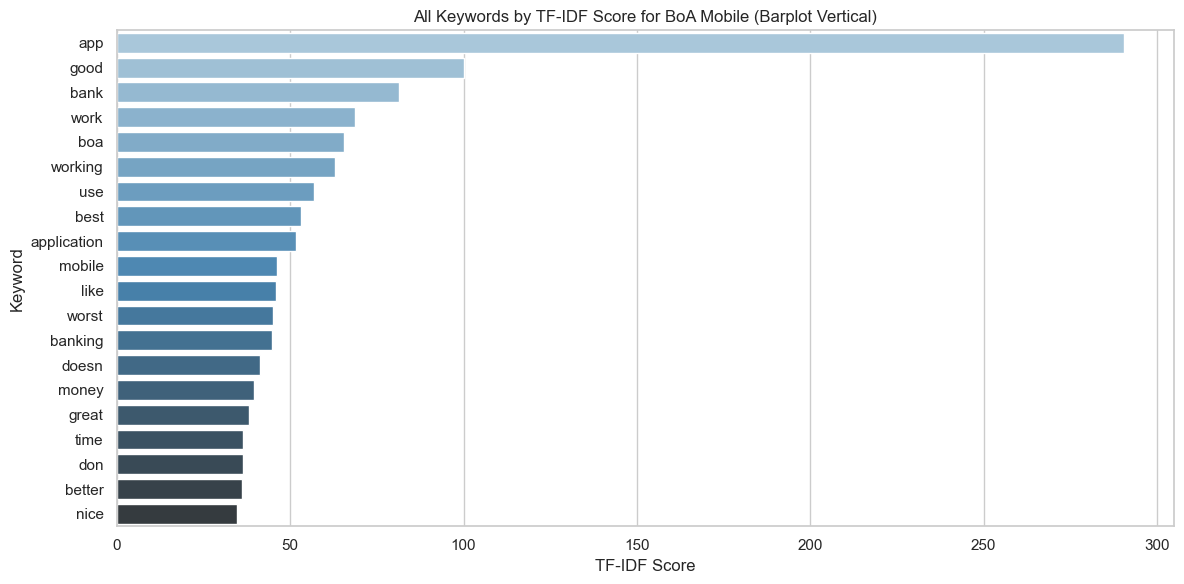

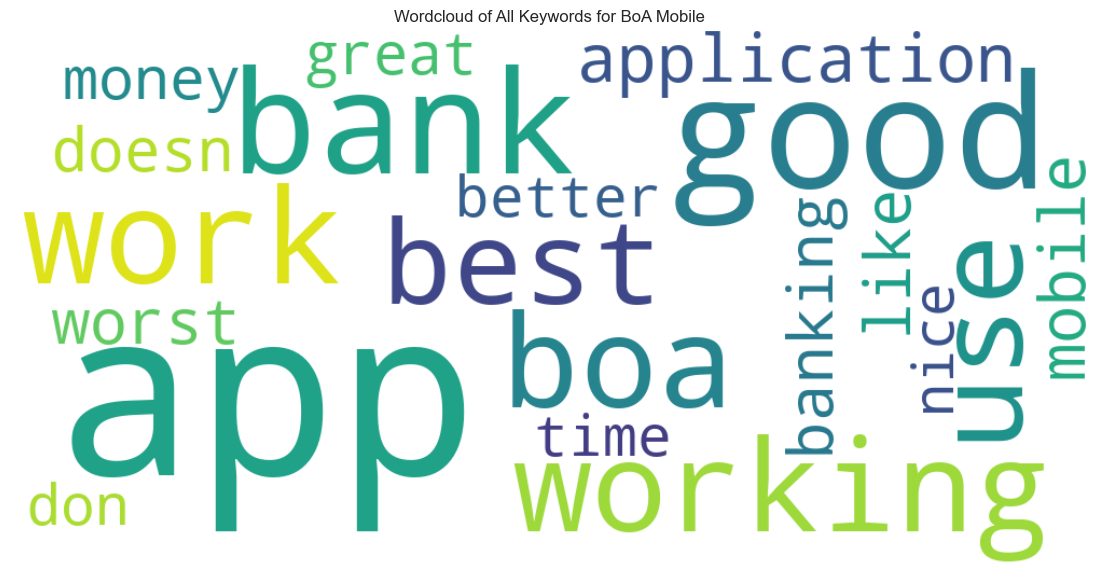

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

banks = boa_keywords_df['app_name'].unique()

for bank in banks:
    # Get all keywords for the current bank
    bank_keywords = boa_keywords_df[boa_keywords_df['app_name'] == bank]

    # Sort by score descending and keep only top 20
    top_keywords = bank_keywords.sort_values(by='score', ascending=False).head(20)

    # 1. Barplot (vertical)
    plt.figure(figsize=(12, max(6, 0.3 * len(top_keywords))))  # dynamic height
    sns.barplot(
        data=top_keywords,
        y='keyword',
        x='score',
        palette='Blues_d',
        hue='keyword',
        legend=False
    )
    plt.title(f"All Keywords by TF-IDF Score for {bank} (Barplot Vertical)")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

    # 2. Wordcloud (weighted by TF-IDF score)
    word_freq = dict(zip(top_keywords['keyword'], top_keywords['score']))
    wordcloud = WordCloud(
        width=1000, height=500,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud of All Keywords for {bank}")
    plt.show()


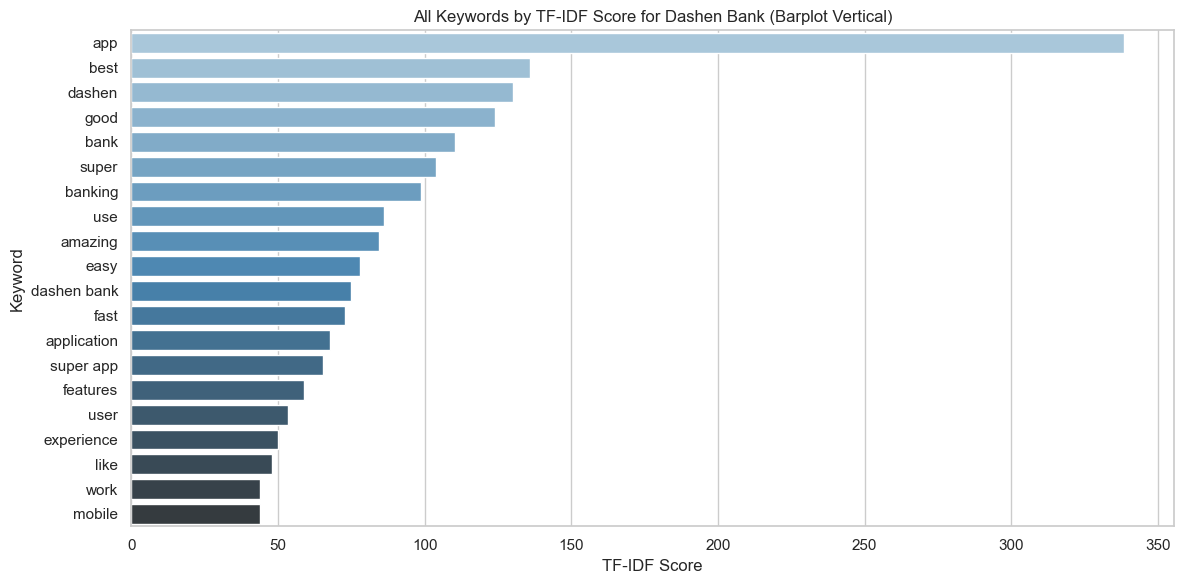

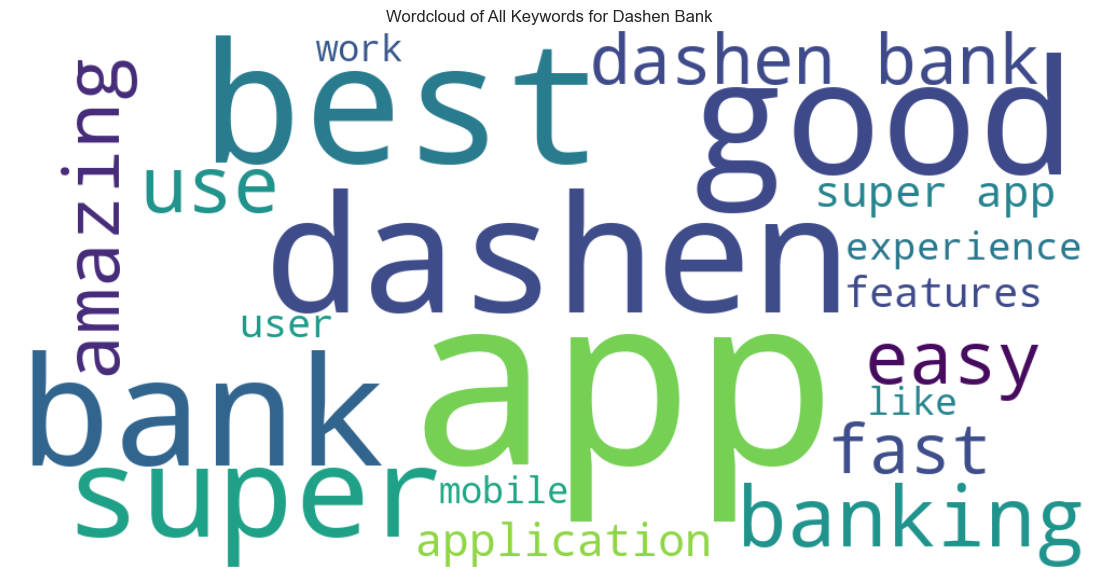

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

banks = dashen_keywords_df['app_name'].unique()

for bank in banks:
    # Get all keywords for the current bank
    bank_keywords = dashen_keywords_df[dashen_keywords_df['app_name'] == bank]

    # Sort by score descending and keep only top 20
    top_keywords = bank_keywords.sort_values(by='score', ascending=False).head(20)

    # 1. Barplot (vertical)
    plt.figure(figsize=(12, max(6, 0.3 * len(top_keywords))))  # dynamic height
    sns.barplot(
        data=top_keywords,
        y='keyword',
        x='score',
        palette='Blues_d',
        hue='keyword',
        legend=False
    )
    plt.title(f"All Keywords by TF-IDF Score for {bank} (Barplot Vertical)")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

    # 2. Wordcloud (weighted by TF-IDF score)
    word_freq = dict(zip(top_keywords['keyword'], top_keywords['score']))
    wordcloud = WordCloud(
        width=1000, height=500,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud of All Keywords for {bank}")
    plt.show()


# 5: Thematic Clustering

In [12]:
from themes import assign_themes_to_keywords

# Assign themes
keywords_with_themes = assign_themes_to_keywords(all_keywords_df)

# Preview
keywords_with_themes.head()


,keyword,score,app_name,theme
0,app,290.351661,BoA Mobile,App Identity
1,good,100.023888,BoA Mobile,User Experience
2,bank,81.320472,BoA Mobile,Banking & Transactions
3,work,68.671213,BoA Mobile,App Performance
4,boa,65.500403,BoA Mobile,App Identity


In [13]:
# Create separate DataFrames for each bank app
cbe_keywords_with_themes = keywords_with_themes[keywords_with_themes["app_name"] == "Commercial Bank of Ethiopia"].reset_index(drop=True)
boa_keywords_with_themes = keywords_with_themes[keywords_with_themes["app_name"] == "BoA Mobile"].reset_index(drop=True)
dashen_keywords_with_themes = keywords_with_themes[keywords_with_themes["app_name"] == "Dashen Bank"].reset_index(drop=True)

# Preview each
print("CBE Keywords:")
print(cbe_keywords_with_themes.head())

print("\nBOA Keywords:")
print(boa_keywords_with_themes.head())

print("\nDashen Keywords:")
print(dashen_keywords_with_themes.head())

CBE Keywords:
  keyword       score                     app_name            theme
0     app  237.068237  Commercial Bank of Ethiopia     App Identity
1    good  184.904206  Commercial Bank of Ethiopia  User Experience
2    best   80.278466  Commercial Bank of Ethiopia  User Experience
3      ነው   73.792401  Commercial Bank of Ethiopia            Other
4     cbe   73.137523  Commercial Bank of Ethiopia     App Identity

BOA Keywords:
  keyword       score    app_name                   theme
0     app  290.351661  BoA Mobile            App Identity
1    good  100.023888  BoA Mobile         User Experience
2    bank   81.320472  BoA Mobile  Banking & Transactions
3    work   68.671213  BoA Mobile         App Performance
4     boa   65.500403  BoA Mobile            App Identity

Dashen Keywords:
  keyword       score     app_name                   theme
0     app  338.547353  Dashen Bank            App Identity
1    best  135.940879  Dashen Bank         User Experience
2  dashen  129.97065

# Visualize Theme Distribution

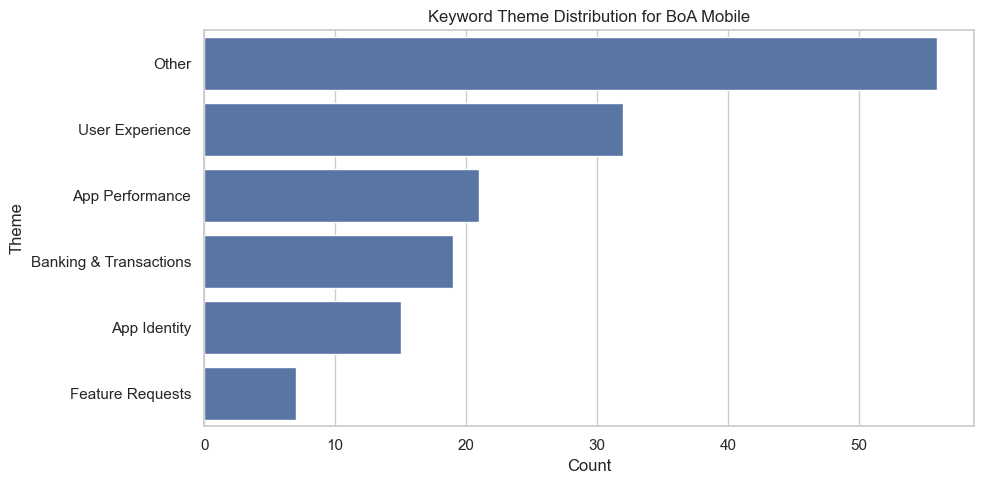

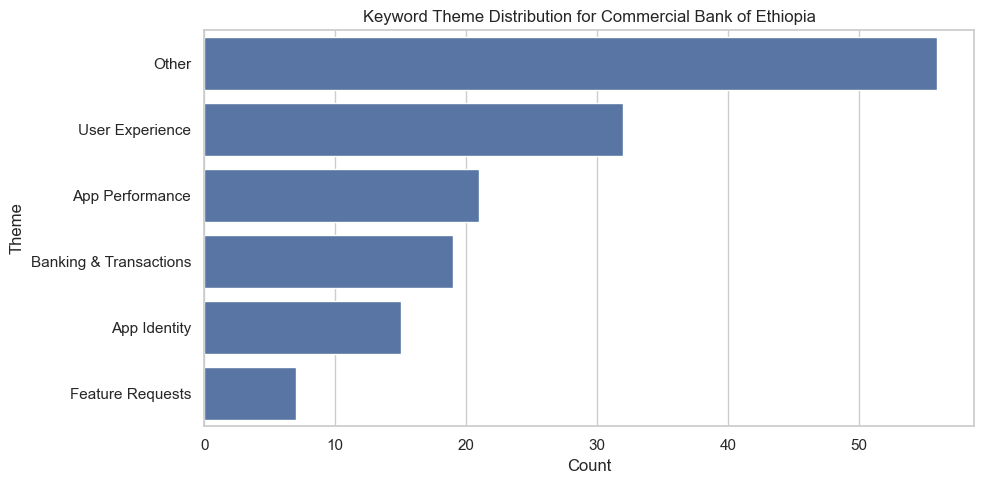

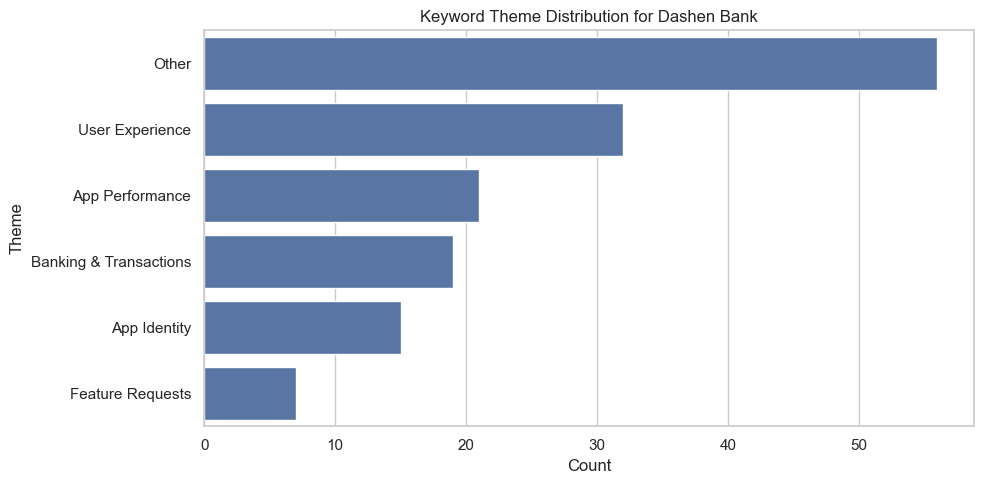

In [14]:
banks = keywords_with_themes['app_name'].unique()  # get all unique bank names

for bank in banks:
    plt.figure(figsize=(10, 5))
    bank_data = keywords_with_themes[keywords_with_themes['app_name'] == bank]
    sns.countplot(data=keywords_with_themes, y='theme', order=keywords_with_themes['theme'].value_counts().index)
    plt.title(f"Keyword Theme Distribution for {bank}")
    plt.xlabel("Count")
    plt.ylabel("Theme")
    plt.tight_layout()
    plt.show()

# 6: Save Output CSV

In [15]:
# Combine all results into df_final
df_final = df.copy()
df_final["keywords"] = keywords_df["keyword"]
df_final["themes"] = keywords_with_themes["theme"]


In [16]:
df_final.head()

,review,rating,review_date,app_name,sentiment_label,sentiment_score,keywords,themes
0,accessible to using,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999117,ahead,App Identity
1,I like it,4,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999859,amazing,User Experience
2,why you change default network?,5,2025-05-23,Commercial Bank of Ethiopia,NEGATIVE,0.996236,app,Banking & Transactions
3,very nice 👍,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999858,application,App Performance
4,nice fast app,5,2025-05-23,Commercial Bank of Ethiopia,POSITIVE,0.999833,bank,App Identity


In [17]:
import os

# Save final DataFrame with selected columns
output_columns = [
    "app_name",
    "rating",
    "review",
    "sentiment_score",
    "sentiment_label",
    "keywords",
    "themes"
]

# Make sure data directory exists
os.makedirs("data", exist_ok=True)

# Save to CSV
output_path = "../data/bank_review_analysis.csv"
df_final[output_columns].to_csv(output_path, index=False)

print(f"✅ Output CSV saved to: {output_path}")



✅ Output CSV saved to: ../data/bank_review_analysis.csv


# Save DataFrame to Oracle

In [18]:
from database import get_engine, insert_dataframe

engine = get_engine()

insert_dataframe(df_final, table_name='bank_review_analysis', engine=engine)

Data inserted successfully into 'bank_review_analysis'.
